# Configure Merge Module Params

This notebook should be used as a test for ensuring correct merge parameters before merge processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for merge processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [3]:
CONFIG_FILE_PATH = "config/config.yml"

In [4]:
import warnings
from pathlib import Path

import yaml
import pandas as pd

from lib.shared.file_utils import get_filename
from lib.shared.configuration_utils import (
    plot_combined_tile_grid,
    plot_merge_example,
    CONFIG_FILE_HEADER,
)
from lib.merge.hash import hash_cell_locations, initial_alignment
from lib.merge.eval_alignment import plot_alignment_quality

## <font color='red'>SET PARAMETERS</font>

### Determine merge plate-well combos
- `MERGE_COMBO_DF_FP`: Plate used for testing configuration

In [5]:
MERGE_COMBO_DF_FP = "config/merge_combo.tsv"

In [6]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

SBS_COMBO_FP = Path(config["preprocess"]["sbs_combo_fp"])
sbs_wildcard_combos = pd.read_csv(SBS_COMBO_FP, sep="\t")
PHENOTYPE_COMBO_FP = Path(config["preprocess"]["phenotype_combo_fp"])
phenotype_wildcard_combos = pd.read_csv(PHENOTYPE_COMBO_FP, sep="\t")

# Generate plate-well combinations for merge
sbs_combos = set(zip(sbs_wildcard_combos["plate"], sbs_wildcard_combos["well"]))
phenotype_combos = set(
    zip(phenotype_wildcard_combos["plate"], phenotype_wildcard_combos["well"])
)
# Check if SBS and PHENOTYPE have the same plate-well combinations
if sbs_combos == phenotype_combos:
    merge_wildcard_combos = pd.DataFrame(list(sbs_combos), columns=["plate", "well"])
else:
    warnings.warn(
        "SBS and PHENOTYPE do not have matching plate-well combinations. Merging requires identical sets."
    )
    merge_wildcard_combos = pd.DataFrame(columns=["plate", "well"])

merge_wildcard_combos.to_csv(MERGE_COMBO_DF_FP, sep="\t", index=False)
merge_wildcard_combos

plate well
0      1   B2

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge module
- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration 

### Parameters for metadata extraction
- `SBS_METADATA_CYCLE`: Cycle number for extracting SBS data positions
- `SBS_METADATA_CHANNEL`: Optional channel for SBS metadata. This is necessary in the case that multiple channel-based images were acquired, and therefore, multiple channel-based metadata files exist.
- `PH_METADATA_CHANNEL`: Optional channel for phenotype metadata. This is necessary in the case that multiple channel-based images were acquired, and therefore, multiple channel-based metadata files exist.

In [7]:
TEST_PLATE = 1
TEST_WELL = "B2"

SBS_METADATA_CYCLE = 1
SBS_METADATA_CHANNEL = None
PH_METADATA_CHANNEL = None

/lab/cheeseman_ops/brieflow-screens/nebo-analysis/brieflow/workflow/lib/shared/configuration_utils.py:307: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_nebo_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_nebo_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


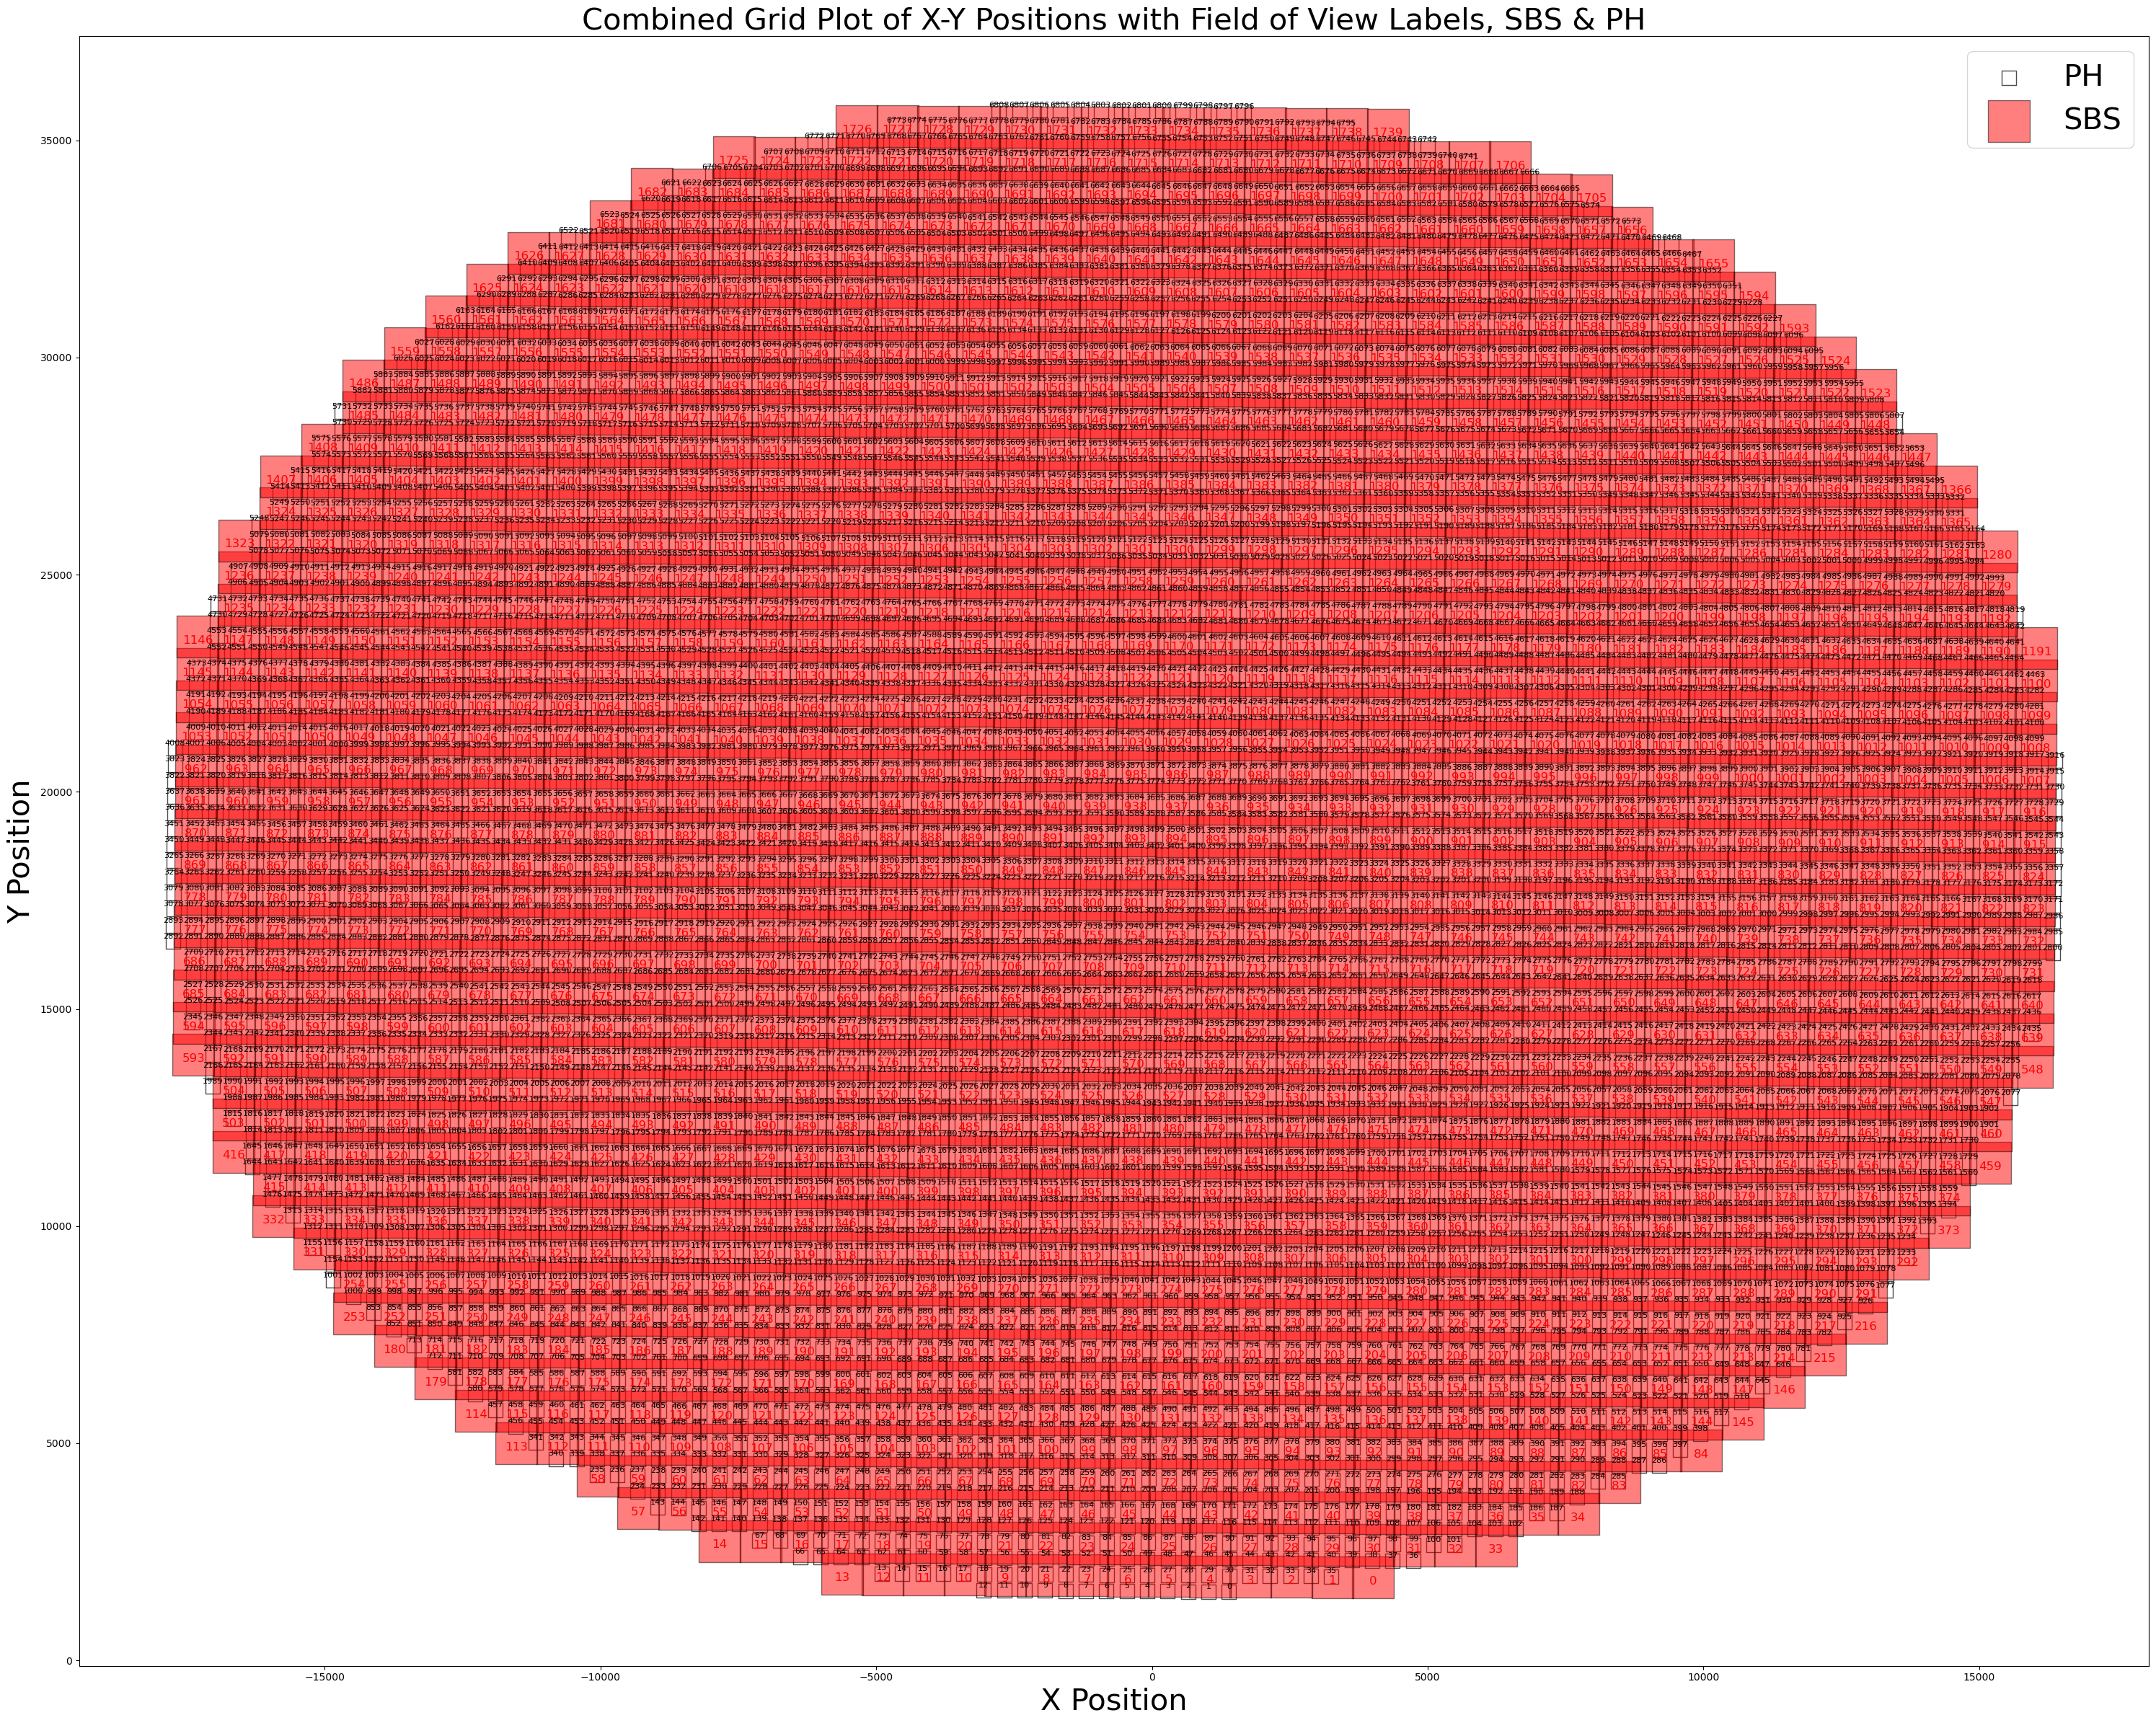

In [8]:
ROOT_FP = Path(config["all"]["root_fp"])

# load phenotype and SBS metadata dfs
ph_filename_params = {"plate": TEST_PLATE, "well": TEST_WELL}
if PH_METADATA_CHANNEL is not None:
    ph_filename_params["channel"] = PH_METADATA_CHANNEL

ph_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "phenotype"
    / get_filename(ph_filename_params, "combined_metadata", "parquet")
)
ph_test_metadata = pd.read_parquet(ph_test_metadata_fp)

sbs_filename_params = {"plate": TEST_PLATE, "well": TEST_WELL}
if SBS_METADATA_CHANNEL is not None:
    sbs_filename_params["channel"] = SBS_METADATA_CHANNEL

sbs_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "sbs"
    / get_filename(sbs_filename_params, "combined_metadata", "parquet")
)
sbs_test_metadata = pd.read_parquet(sbs_test_metadata_fp)
sbs_test_metadata = sbs_test_metadata[sbs_test_metadata["cycle"] == SBS_METADATA_CYCLE]

# create plot with combined tile view
combined_tile_grid = plot_combined_tile_grid(ph_test_metadata, sbs_test_metadata)
combined_tile_grid.show()

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge processing

- `INITIAL_SITES`: Combinations of phenotype and SBS tiles used for configuring merge module parameters. Based on the combined grid above, set 6 aligned intial sites. We will load images for one of those sites, to ensure that we can visualize cell patterns (using the DAPI channel) that correspond between two tiles that will make up our initial sites. We recommend using aligned sites from across the plate.

In [26]:
# INITIAL_SITES = [[84, 5], [1067, 62], [2714, 170], [4613, 291], [6203, 404], [6589, 437]] 10x to 40x
INITIAL_SITES = [[166, 45], [1066, 286], [1356, 354], [2361, 602], [4443, 1110], [6626, 1685]] # 20x to 40x

In [27]:
# Derive sites for phenotype and sbs
phenotype_tiles = [site[0] for site in INITIAL_SITES]
sbs_tiles = [site[1] for site in INITIAL_SITES]

# Derive phenotype alignment hash
phenotype_info_fp = (
    ROOT_FP
    / "phenotype"
    / "parquets"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL}, "phenotype_info", "parquet"
    )
)
phenotype_info = pd.read_parquet(phenotype_info_fp)
phenotype_info_hash = hash_cell_locations(phenotype_info)

# Derive SBS alignment hash
sbs_info_fp = (
    ROOT_FP
    / "sbs"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "sbs_info", "parquet")
)
sbs_info = pd.read_parquet(sbs_info_fp)
sbs_info_hash = hash_cell_locations(sbs_info).rename(columns={"tile": "site"})

# Perform alignment for initial sites
initial_alignment_df = initial_alignment(
    phenotype_info_hash, sbs_info_hash, initial_sites=INITIAL_SITES
)
initial_alignment_df

rotation  \
0  [[0.24756821088823724, -0.0006663734156815062]...   
1  [[0.24797479306979153, 0.0005737735209652089],...   
2  [[0.2488831842753998, 2.972526821195739e-05], ...   
3  [[0.24909997250938404, -0.00013495738633675114...   
4  [[0.24872960158983667, -1.992934953143296e-05]...   
5  [[0.24885534662479766, 0.0004569560308330025],...   

                               translation     score  determinant  site  tile  
0  [302.12705546734514, 306.4809256765428]  0.727273     0.061706    45   166  
1  [299.5285208205072, 303.11891737459405]  0.466667     0.062259   286  1066  
2   [300.8366291807101, 305.3213653876058]  0.781250     0.061914   354  1356  
3   [302.6105733707595, 304.3943596438619]  0.761905     0.062009   602  2361  
4  [299.3133469295831, 301.14585426066054]  0.509804     0.061896  1110  4443  
5   [301.8963944616374, 301.3085758482274]  0.759259     0.061854  1685  6626

## <font color='red'>SET PARAMETERS</font>

### Visualize gating strategy based on initial alignment

- `DET_RANGE`: Enforces valid magnification ratios between phenotype and genotype images. It needs to be adjusted based on:
    - Objective magnifications used (e.g., 20X vs 10X)
    - Camera binning settings (e.g., 2x2 binning vs unbinned)
    - To calculate for your setup:
        1. Determine total magnification difference (objectives × binning)
        2. Use (min/difference², max/difference²) where min/max are typically 0.9-1.15
    - You can narrow or expand the suggested `DET_RANGE` based on how closely or widely you want to ensure matches
- `SCORE` This parameter is the score of the transformation, typically 0.1

In [28]:
# DET_RANGE = (0.015, 0.017) # 10x to 40x
DET_RANGE = (0.056, 0.072)  # 20x to 40x
SCORE = 0.1

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Alignment Quality Check\nScore vs Determinant'}, xlabel='Determinant', ylabel='Score'>)

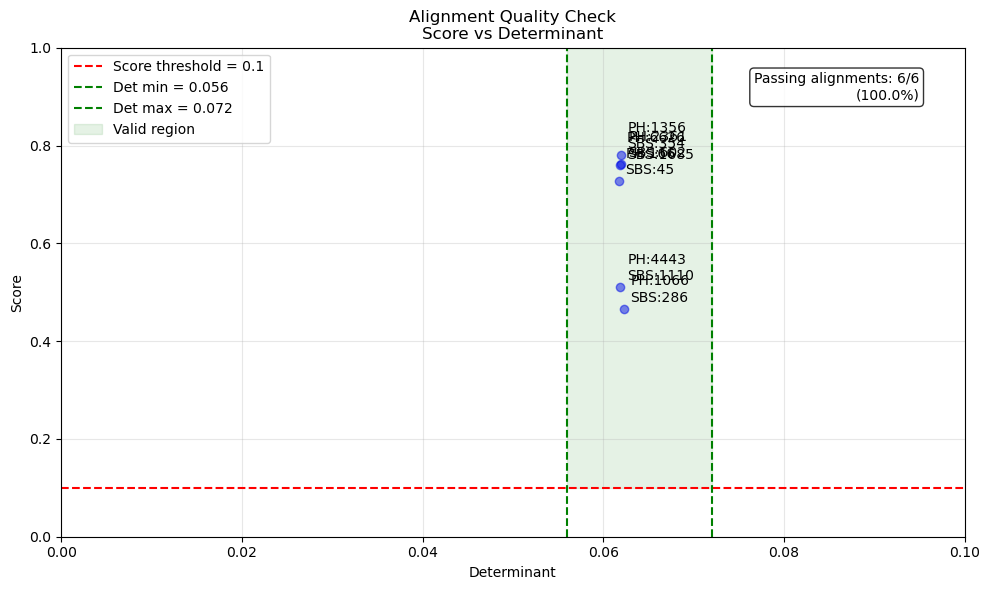

In [29]:
plot_alignment_quality(
    initial_alignment_df, det_range=DET_RANGE, score=SCORE, xlim=(0, 0.1), ylim=(0, 1)
)

## <font color='red'>SET PARAMETERS</font>

### Visualize cell matches based on initial alignment

- `THRESHOLD`: Determines the maximum euclidean distance between a phenotype point and its matched SBS point for them to be considered a valid match

In [38]:
# THRESHOLD = 10 # 10x to 40x
THRESHOLD = 5  # 20x to 40x

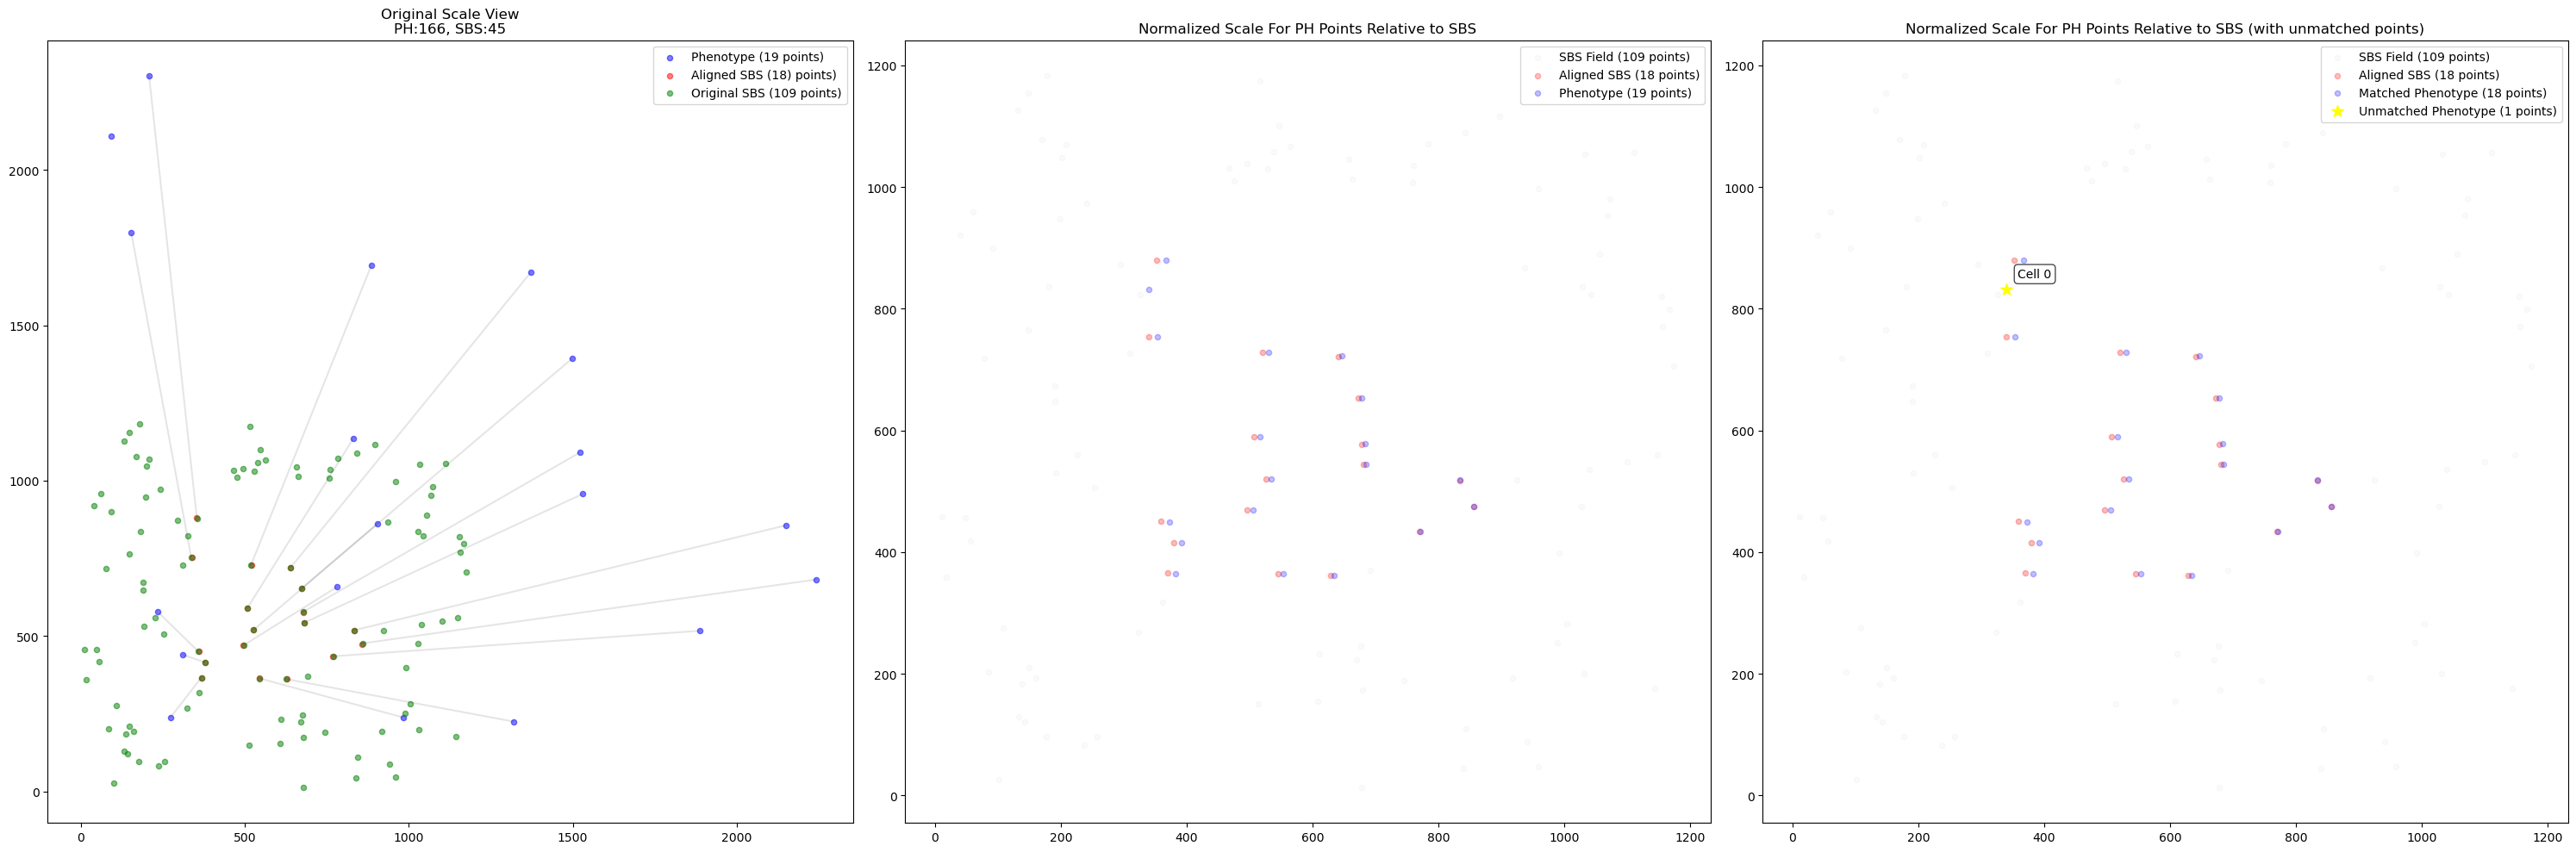

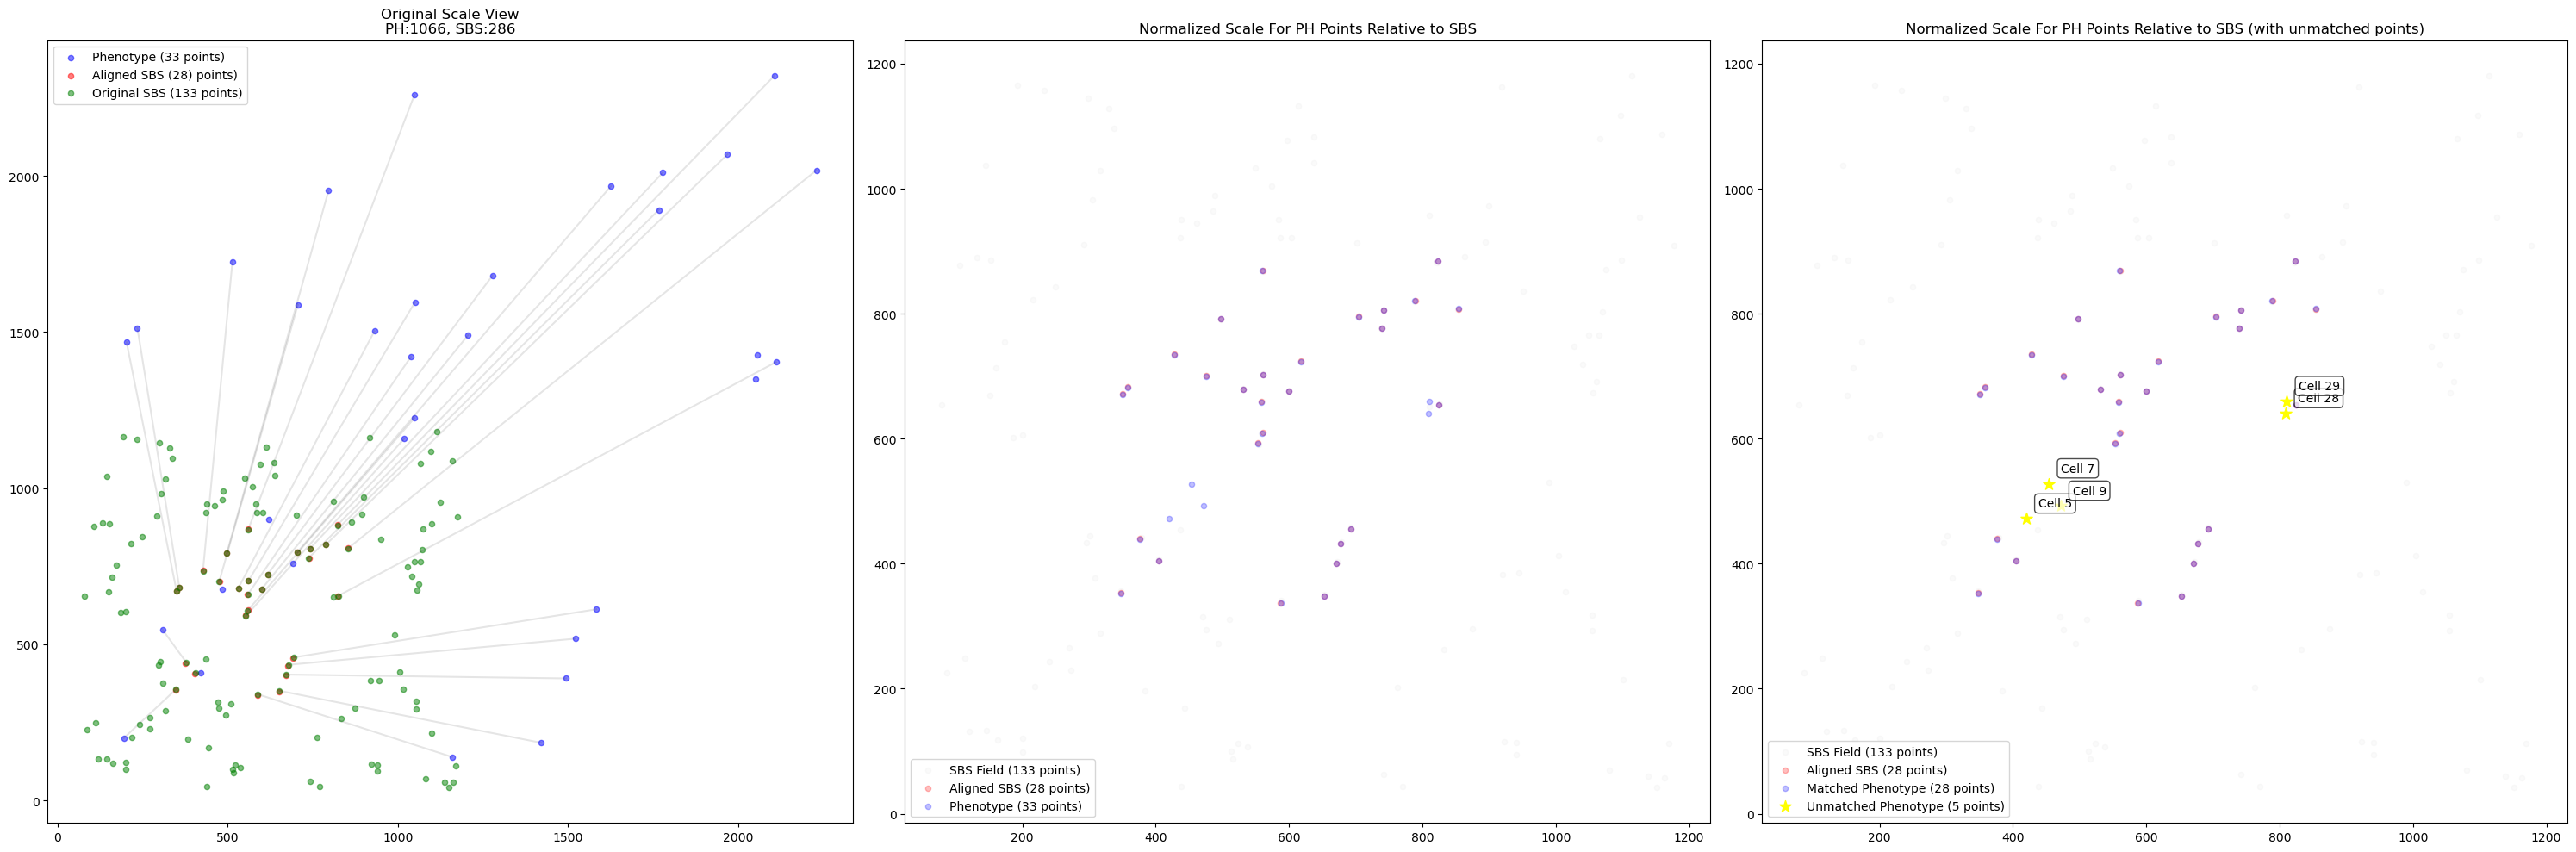

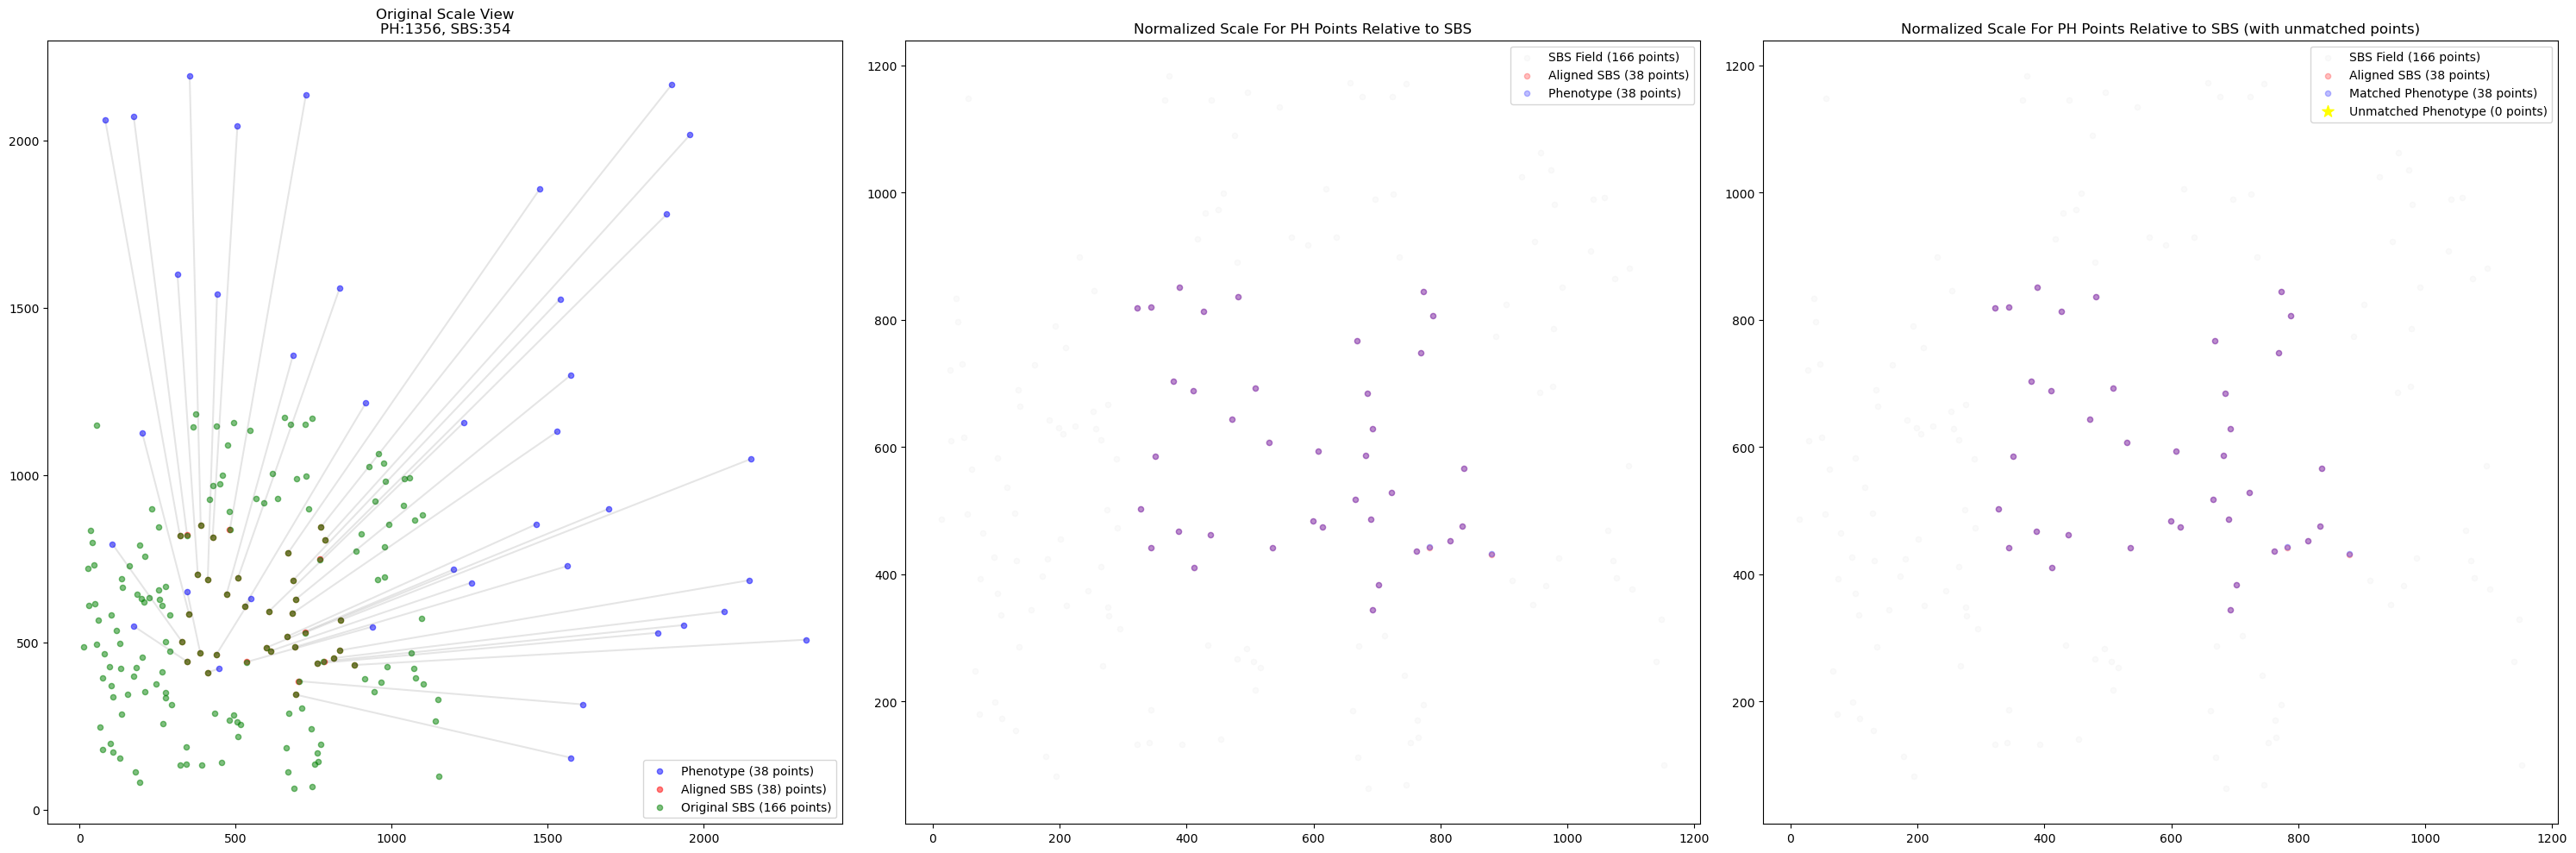

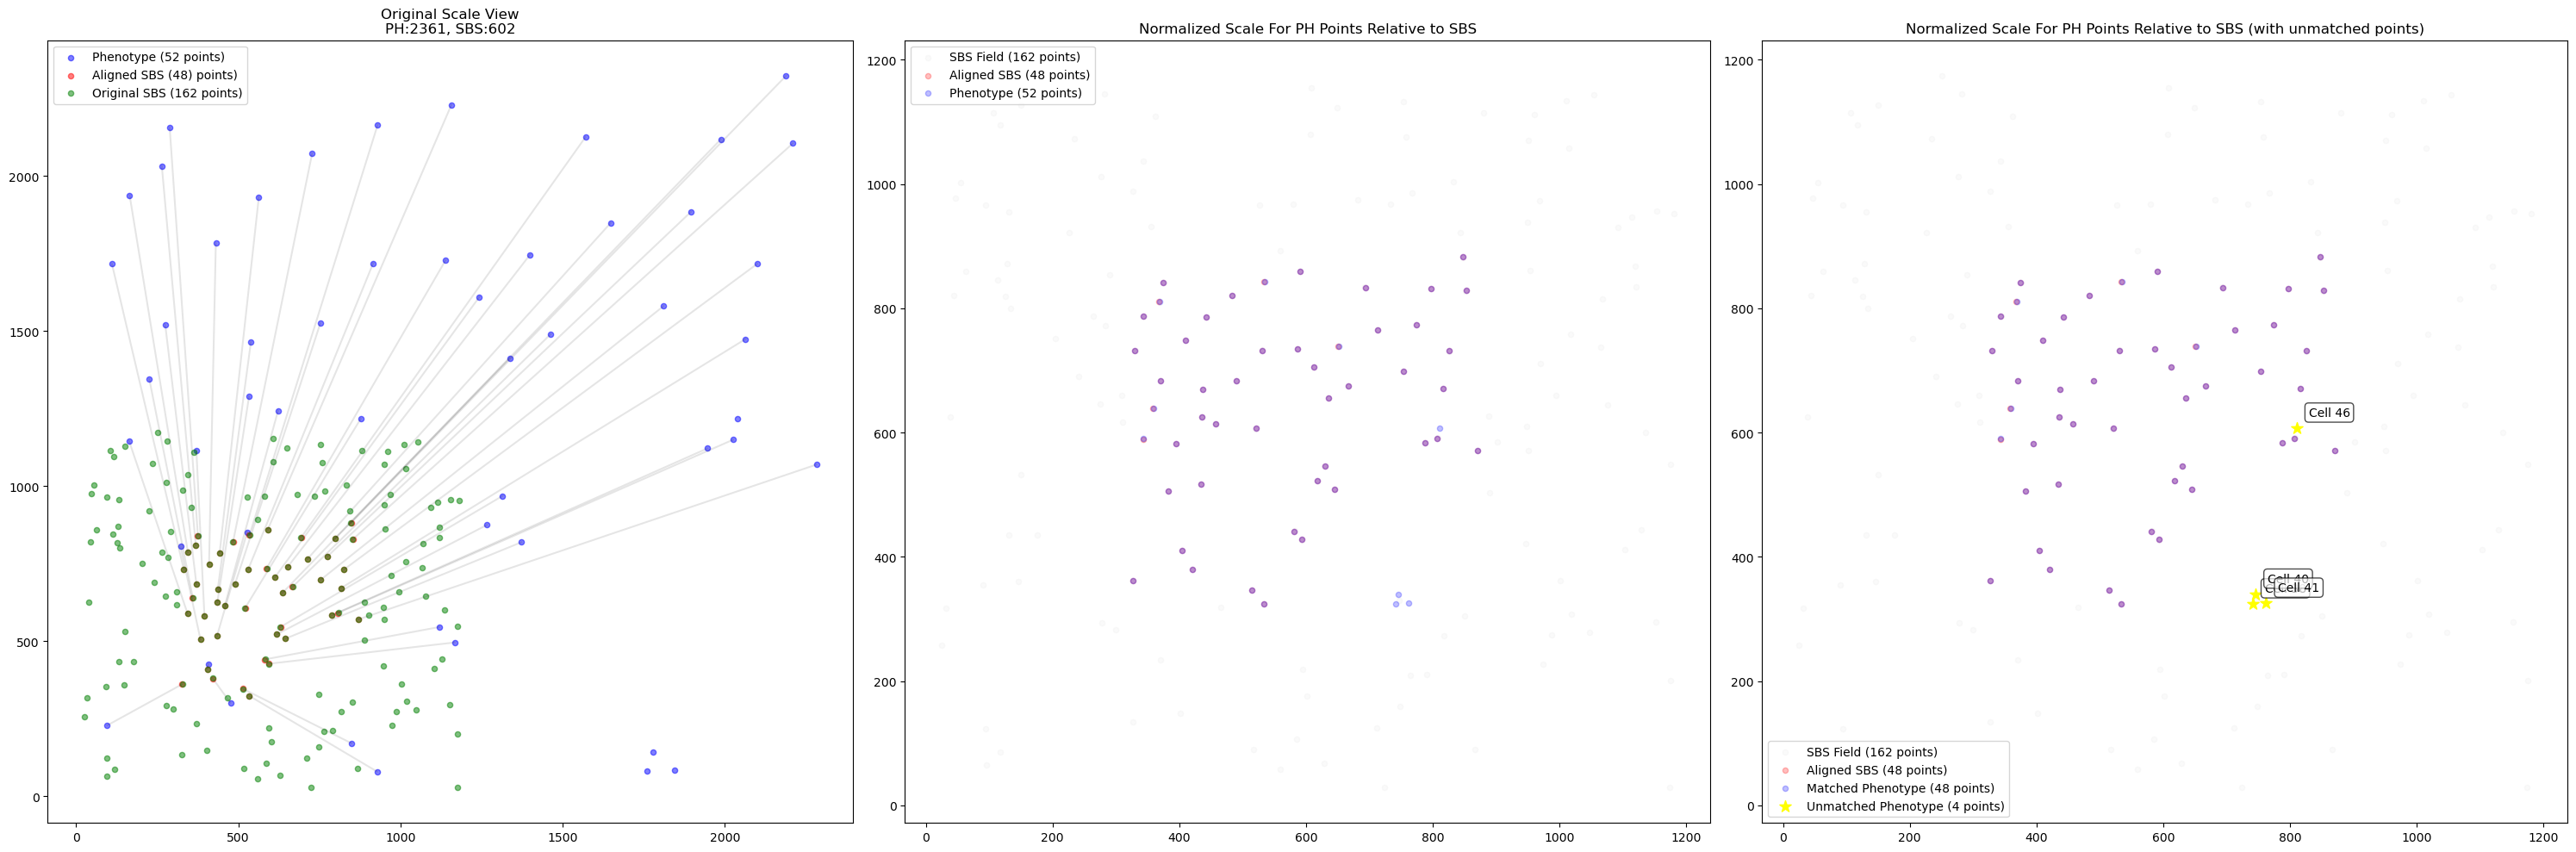

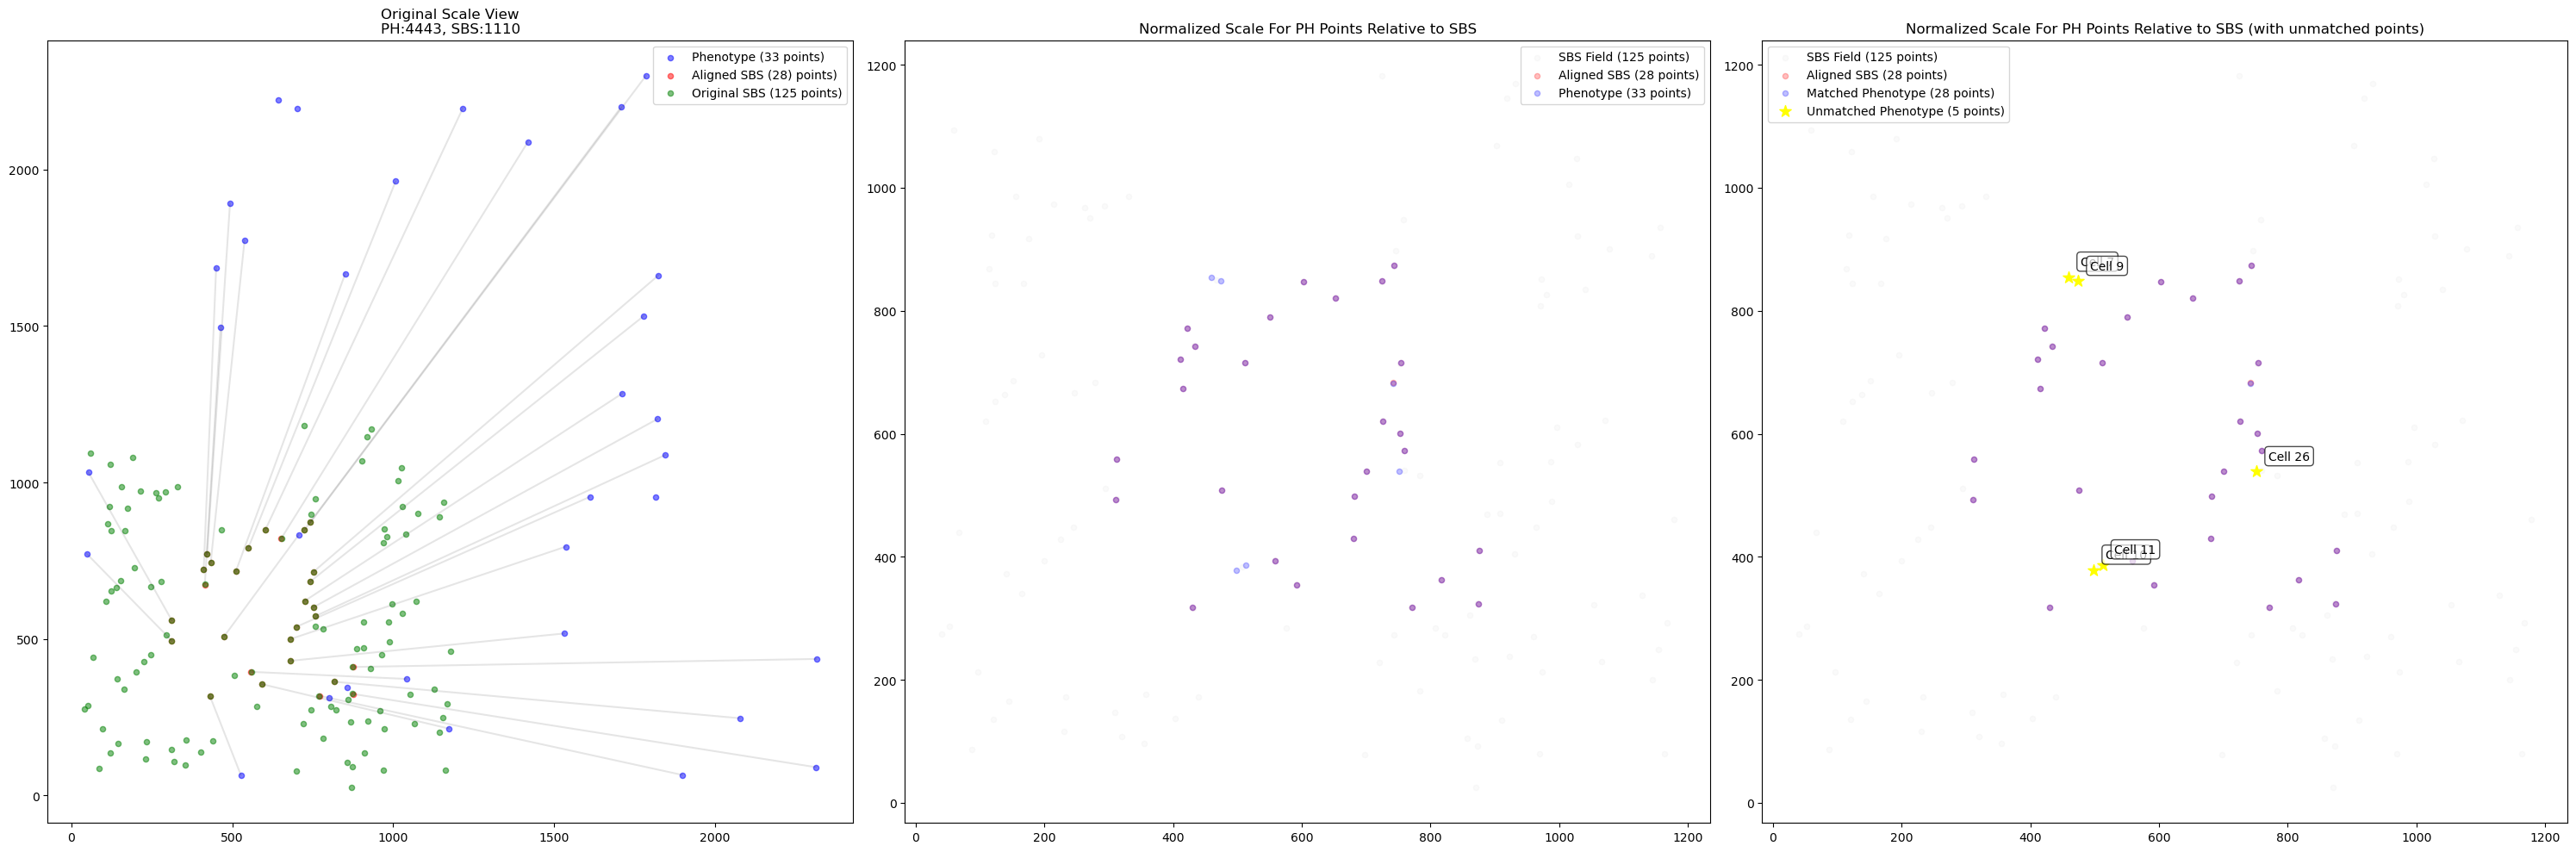

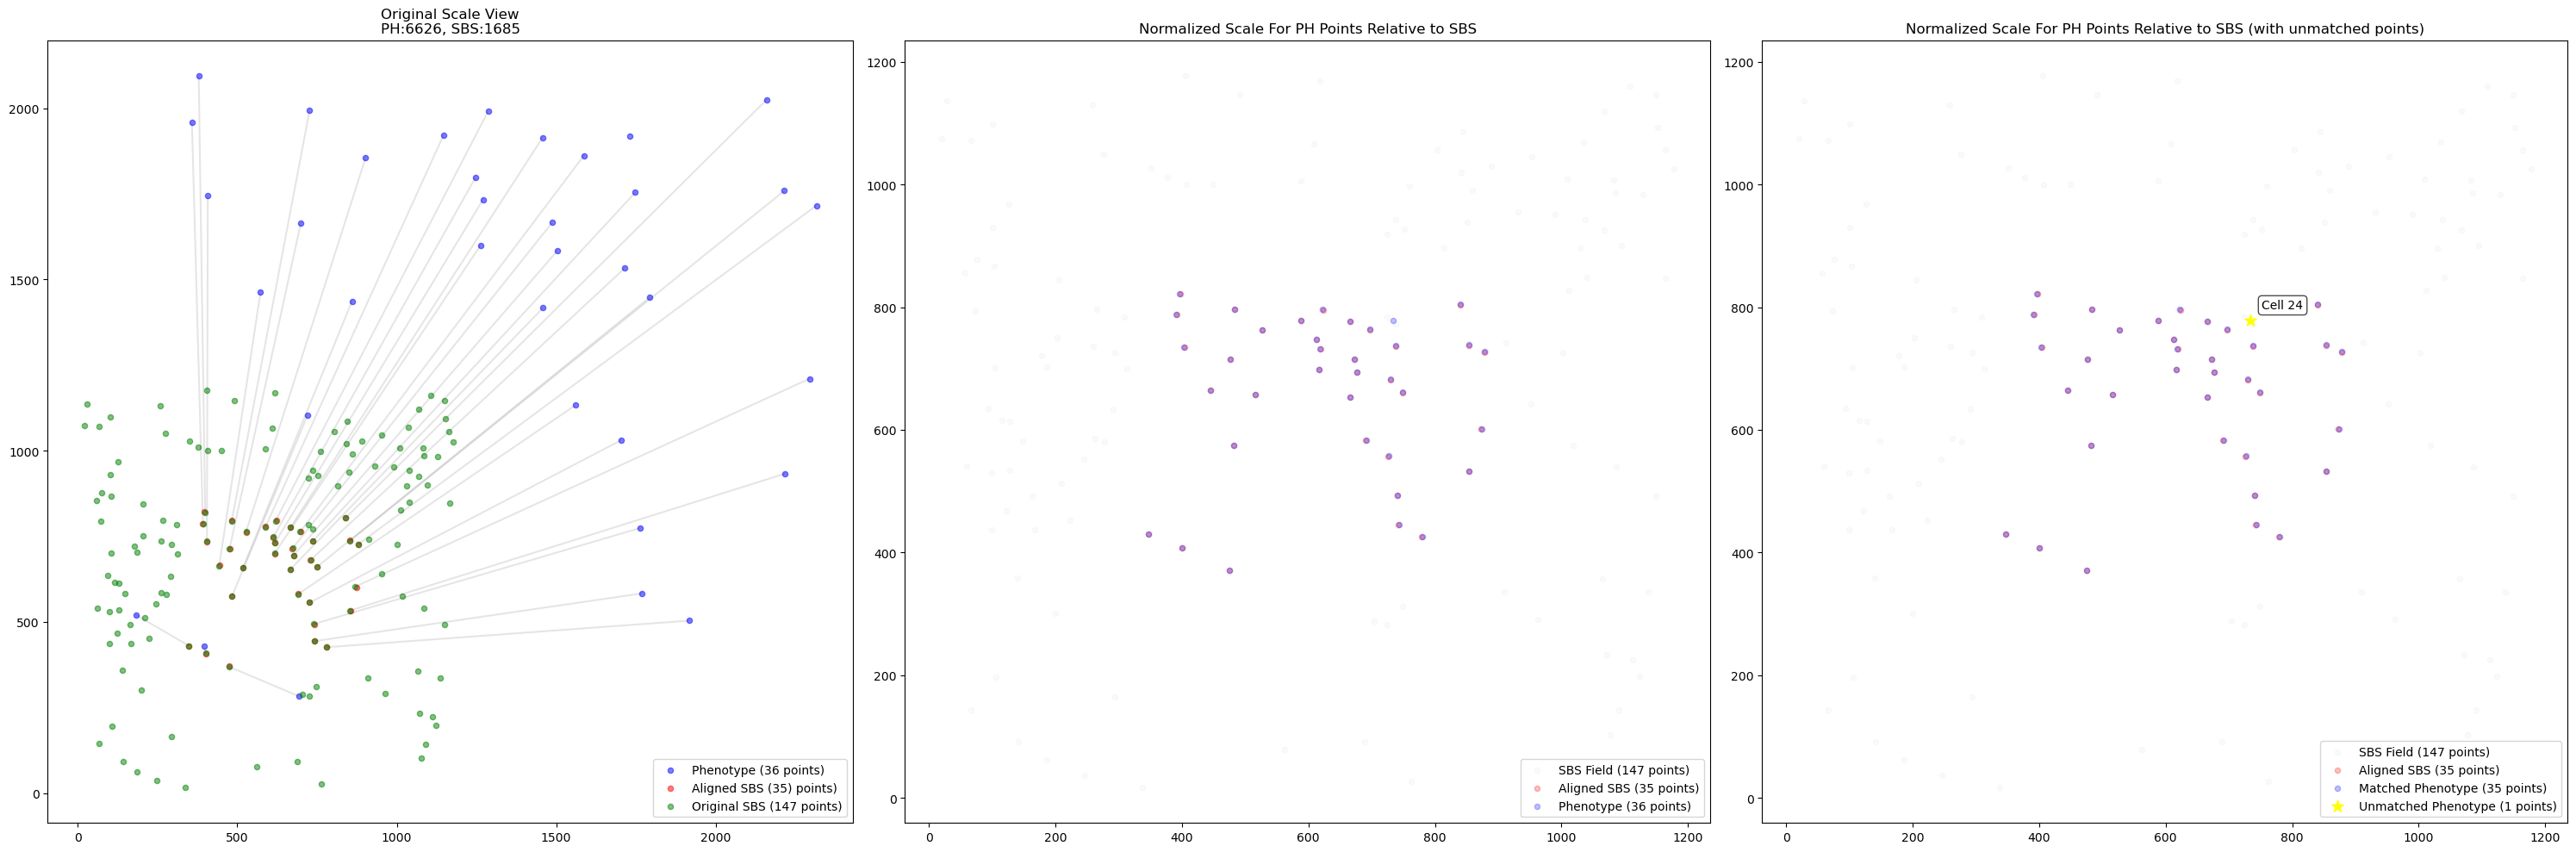

In [39]:
# Loop through all initial site pairs and create plots for each
for site_pair in INITIAL_SITES:
    ph_tile = site_pair[0]
    sbs_site = site_pair[1]
    
    # Get the alignment vector for this site pair
    alignment_vec = initial_alignment_df[
        (initial_alignment_df["tile"] == ph_tile) & 
        (initial_alignment_df["site"] == sbs_site)
    ]
    
    # Check if we found a valid alignment for this pair
    if not alignment_vec.empty:
        alignment_vec = alignment_vec.iloc[0]
        
        # Create the plot for this site pair
        plot_merge_example(
            phenotype_info,
            sbs_info,
            alignment_vec,
            threshold=THRESHOLD,
        )
    else:
        print(f"No valid alignment found for PH tile {ph_tile} and SBS site {sbs_site}")

## Add merge parameters to config file

In [40]:
# Add merge section
config["merge"] = {
    "merge_combo_fp": MERGE_COMBO_DF_FP,
    "sbs_metadata_cycle": SBS_METADATA_CYCLE,
    "sbs_metadata_channel": SBS_METADATA_CHANNEL,
    "ph_metadata_channel": PH_METADATA_CHANNEL,
    "initial_sites": INITIAL_SITES,
    "det_range": DET_RANGE,
    "score": SCORE,
    "threshold": THRESHOLD,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-stylåe comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)

In [41]:
from lib.shared.eval import plot_plate_heatmap
import pandas as pd

merge_data = pd.read_parquet("/lab/cheeseman_ops/brieflow-screens/nebo-analysis/analysis/analysis_root/merge/parquets/P-1_W-B2__merge.parquet")
tile_counts = merge_data.groupby(['plate', 'well', 'site']).size().reset_index(name='count')
tile_counts.rename(columns={'site': 'tile'}, inplace=True)

In [42]:
merge_data.to_csv(
    "/lab/cheeseman_ops/brieflow-screens/nebo-analysis/analysis/analysis_root/merge/parquets/P-1_W-B2__merge.csv",
    index=False,
)

(<Figure size 1000x1000 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f10b441b2d0>)

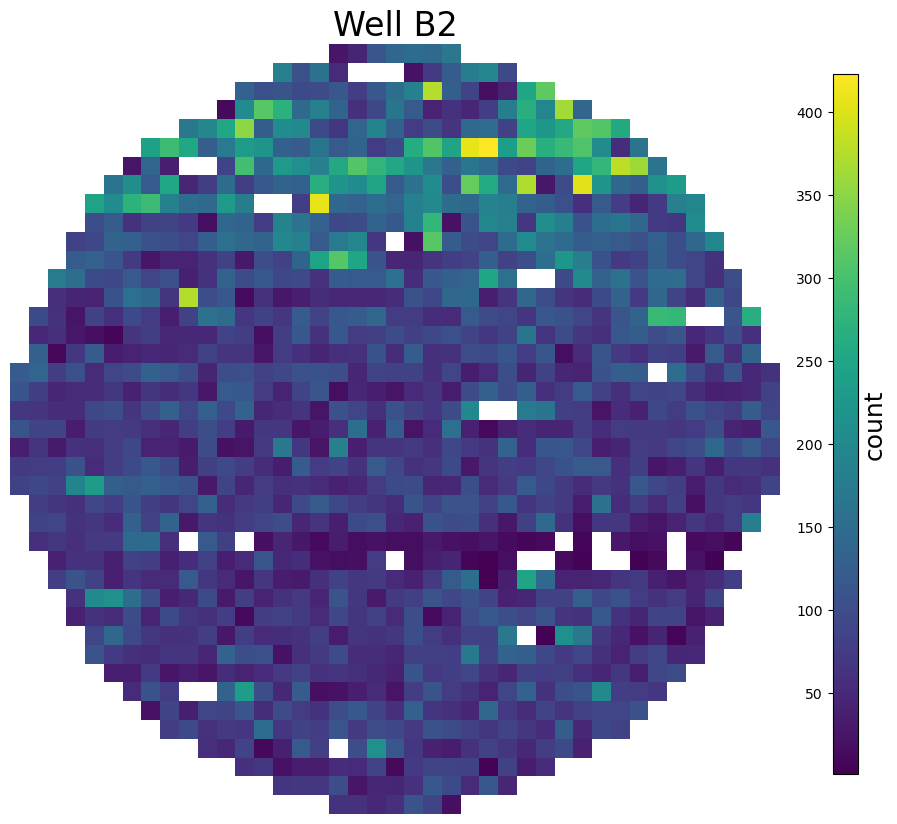

In [43]:
plot_plate_heatmap(tile_counts, metric='count', shape="6W_ph")

In [44]:
from lib.shared.eval import plot_plate_heatmap
import pandas as pd

fast_alignment = pd.read_parquet("/lab/cheeseman_ops/brieflow-screens/nebo-analysis/analysis/analysis_root/merge/parquets/P-1_W-B2__fast_alignment.parquet")

In [45]:
fast_alignment.to_csv(
    "/lab/cheeseman_ops/brieflow-screens/nebo-analysis/analysis/analysis_root/merge/parquets/P-1_W-B2__fast_alignment.csv",
    index=False,
)